In [ ]:
from nnsight import NNsight
import torch 
from transformers import GPTJForCausalLM, AutoTokenizer 
from IPython.display import clear_output
from nnsight import LanguageModel
from typing import List, Callable
import torch
import numpy as np
import circuitsvis as cv
import matplotlib.pyplot as plt
import seaborn as sns
 
model_path = "/data/lmm/checkpoints/lm/checkpoint-1953"
gptj = GPTJForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = LanguageModel(gptj,tokenizer=tokenizer)
torch.set_grad_enabled(False)

/home/allanz/miniconda3/envs/vlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OSError: Incorrect path_or_model_id: '/data/lmm/checkpoints/checkpoint-1953'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [8]:
prompt= """| deer | cat | bird |
| deer | cat | cat |
| bird | dog | bird |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].
What object is in row 1, column 2? A: 
"""

layers = model.transformer.h
attn_out = []

from torch import nn

with model.trace(output_attentions=True) as tracer:
    with tracer.invoke(prompt) as invoker:
        for i, layer in enumerate(layers):
            attn_out.append(layer.attn.output.save())



# Access the 'input_ids' attribute of the invoker object to get the input words
input_words = [model.tokenizer.decode(t) for t in invoker.inputs[0]["input_ids"][0]]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [9]:
# I think first element is ouput after going through attention heads
# Not sure the difference between the second and third element. I think third is normalized to fall between 0 and 1, not entirely sure

print(len(attn_out)) # Num Layers

12


In [14]:
print(attn_out[0][2][0][0].sum(axis=1)) # Check if rows add up to 1 -> Attention weights should!

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])


In [25]:
def custom_heatmap(layer, head=None):
    attention_weights = attn_out[layer][2][0]
    if head is not None:
        attention_weights = attention_weights[head].squeeze().detach().cpu().numpy()
        plt.figure(figsize=(10, 8))
        plt.title(f"Attention Weights for Layer {layer} Head {head}")
        sns.heatmap(attention_weights, cmap="coolwarm", annot=False, fmt=".2f", cbar=True, vmin=0, vmax=1)
    else:
        attention_weights_sum = attention_weights.sum(axis=0).detach().cpu().numpy()
        plt.figure(figsize=(10, 8))
        plt.title(f"Sum of Attention Weights for Layer {layer}")
        sns.heatmap(attention_weights_sum, cmap="coolwarm", annot=False, fmt=".2f", cbar=True, vmin=0, vmax=1)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))
    plt.show()


In [24]:
import circuitsvis as cv

LAYER_NUM = 3
print(f"Layer {LAYER_NUM} Summed Attention Patterns:")
cv.attention.AttentionVisualizer(tokens=input_words[:64], attention=np.sum(attn_out[LAYER_NUM][2], axis=0))

Layer 3 Summed Attention Patterns:


AttributeError: module 'circuitsvis.attention' has no attribute 'AttentionVisualizer'

In [ ]:
import circuitsvis as cv

LAYER_NUM = 3
print(f"Layer {LAYER_NUM} Head Attention Patterns:")
cv.attention.attention_heads(tokens=input_words[:64], attention=attn_out[LAYER_NUM][2][0])

# attn_out[layer #][1][head #][0]

Layer 3 Head Attention Patterns:


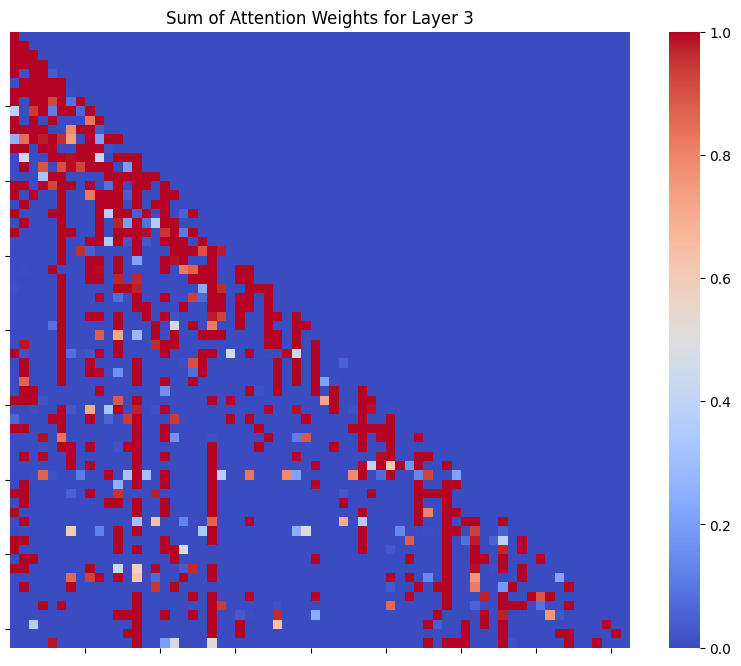

In [26]:
custom_heatmap(3)